In [1]:
import folium
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from datetime import timedelta
# Mapping
import geopandas
import geopy
from geopy.geocoders import Nominatim
import folium
from geopy.extra.rate_limiter import RateLimiter
from folium import plugins
from folium.plugins import MarkerCluster
# Statistical OLS Regression Analysis
%matplotlib inline
import statsmodels.api as sm
from statsmodels.compat import lzip
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

df = pd.read_csv('/Users/rupaliwadhawan/Downloads/AI_locations.csv')
toronto_map = folium.Map(location=[43.70, -79.42], zoom_start=12)


In [2]:
df = pd.read_csv('/Users/rupaliwadhawan/Downloads/AI_locations.csv')

In [3]:
df.head()

,X,Y,OBJECTID,EVENT_UNIQUE_ID,OCC_DATE,OCC_YEAR,OCC_MONTH,OCC_DOW,OCC_DOY,OCC_DAY,...,OCC_TIME_RANGE,DIVISION,DEATH,INJURIES,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,LONG_WGS84,LAT_WGS84
0,-79.234955,43.781528,1,GO-2004397105,2004/05/15 04:00:00+00,2004,May,Saturday,136,15,...,Night,D41,0,0,142,Woburn North,137,Woburn (137),-79.234955,43.781528
1,-79.618218,43.733547,2,GO-2004600109,2004/07/26 04:00:00+00,2004,July,Monday,208,26,...,Evening,D23,0,0,1,West Humber-Clairville,1,West Humber-Clairville (1),-79.618218,43.733547
2,-79.518759,43.769157,3,GO-2004311851,2004/05/14 04:00:00+00,2004,May,Friday,135,14,...,Afternoon,D31,1,1,24,Black Creek,24,Black Creek (24),-79.518759,43.769157
3,-79.378870,43.660665,4,GO-2004736004,2004/12/19 05:00:00+00,2004,December,Sunday,354,19,...,Night,D51,1,0,168,Downtown Yonge East,75,Church-Yonge Corridor (75),-79.378870,43.660665
4,-79.212435,43.812075,5,GO-2004303455,2004/04/12 04:00:00+00,2004,April,Monday,103,12,...,Evening,D42,0,0,146,Malvern East,132,Malvern (132),-79.212435,43.812075


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5707 entries, 0 to 5706
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   X                  5707 non-null   float64
 1   Y                  5707 non-null   float64
 2   OBJECTID           5707 non-null   int64  
 3   EVENT_UNIQUE_ID    5707 non-null   object 
 4   OCC_DATE           5707 non-null   object 
 5   OCC_YEAR           5707 non-null   int64  
 6   OCC_MONTH          5707 non-null   object 
 7   OCC_DOW            5707 non-null   object 
 8   OCC_DOY            5707 non-null   int64  
 9   OCC_DAY            5707 non-null   int64  
 10  OCC_HOUR           5707 non-null   int64  
 11  OCC_TIME_RANGE     5707 non-null   object 
 12  DIVISION           5707 non-null   object 
 13  DEATH              5707 non-null   int64  
 14  INJURIES           5707 non-null   int64  
 15  HOOD_158           5707 non-null   object 
 16  NEIGHBOURHOOD_158  5707 

In [5]:
heat_data = [[row['LAT_WGS84'], row['LONG_WGS84']] for index, row in df.iterrows()]
from folium.plugins import HeatMap
HeatMap(heat_data).add_to(toronto_map)
toronto_map.save('crime_heatmap_1.html')

In [8]:
from sklearn.ensemble import GradientBoostingRegressor
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Convert time objects
df['OCC_DATE'] = pd.to_datetime(df['OCC_DATE'])
df['date'] = [d.date() for d in df['OCC_DATE']]
df['time'] = [d.time() for d in df['OCC_DATE']]
df['day'] = df['OCC_DATE'].dt.day_name()
# Find Fractions of Day
df['timeint'] = (df['OCC_DATE']-df['OCC_DATE'].dt.normalize()).dt.total_seconds()/timedelta(days=1).total_seconds()

<Figure size 640x480 with 0 Axes>

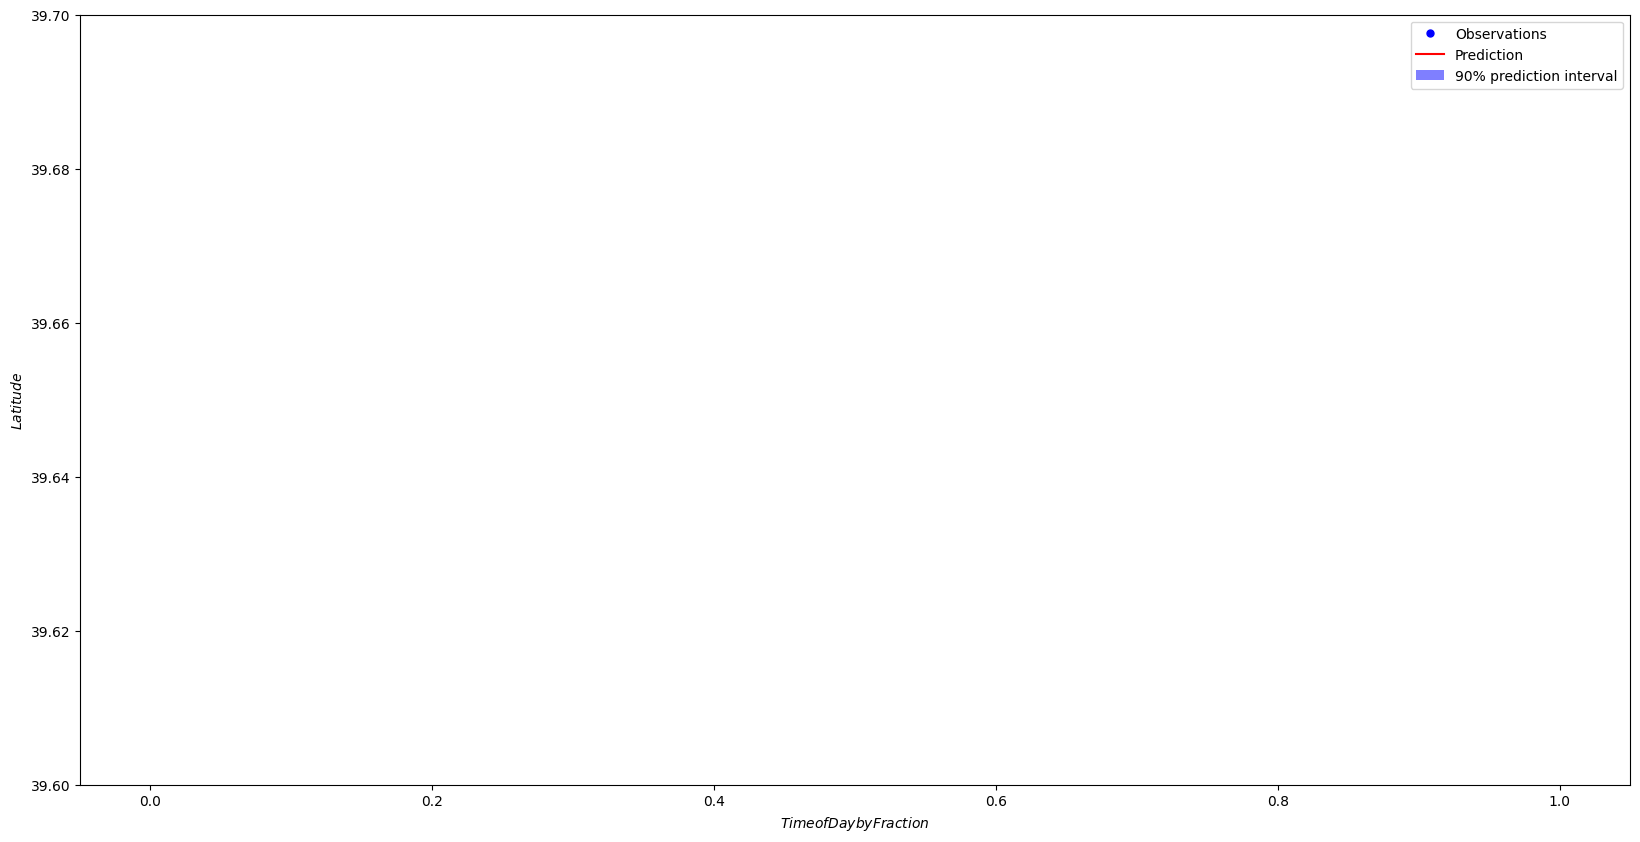

In [15]:
#  First the noiseless case
X = np.atleast_2d(df['timeint'].values).T
# Observations
y = np.atleast_2d(df['LAT_WGS84'].values).T
y = y.ravel()
# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
xx = np.atleast_2d(np.linspace(0, 1, 913)).T
xx = xx.astype(np.float32)
alpha = 0.95
clf = GradientBoostingRegressor(loss='huber',  # Try 'ls' for least squares or 'lad' for least absolute deviation
                                n_estimators=1000,  # Increase the number of estimators
                                max_depth=5,  # Increase the depth of the trees
                                learning_rate=0.01)
clf.fit(X, y)
# Make the prediction on the meshed x-axis
y_upper = clf.predict(xx)
clf.set_params(alpha=1.0 - alpha)
clf.fit(X, y)
# Make the prediction on the meshed x-axis
y_lower = clf.predict(xx)
clf.set_params(loss='quantile')
clf.fit(X, y)
# Make the prediction on the meshed x-axis
y_pred = clf.predict(xx)
# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.plot(X, np.ravel(y), 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('$Time of Day by Fraction$')
plt.ylabel('$Latitude$')
plt.ylim(39.6, 39.7)
plt.legend(loc='upper right')
plt.show()
ypred2 = y_pred


X shape: (5707, 1)
y shape: (5707,)
XX shape: (913, 1)
X data: [[0.16666667]
 [0.16666667]
 [0.16666667]
 [0.20833333]
 [0.16666667]]
y data: [43.78152799 43.73354689 43.76915718 43.66066473 43.81207513]
y_pred: [43.63936285 43.63936285 43.63936285 43.63936285 43.63936285]
y_upper: [43.78096992 43.78096992 43.78096992 43.78096992 43.78096992]
y_lower: [43.63936285 43.63936285 43.63936285 43.63936285 43.63936285]


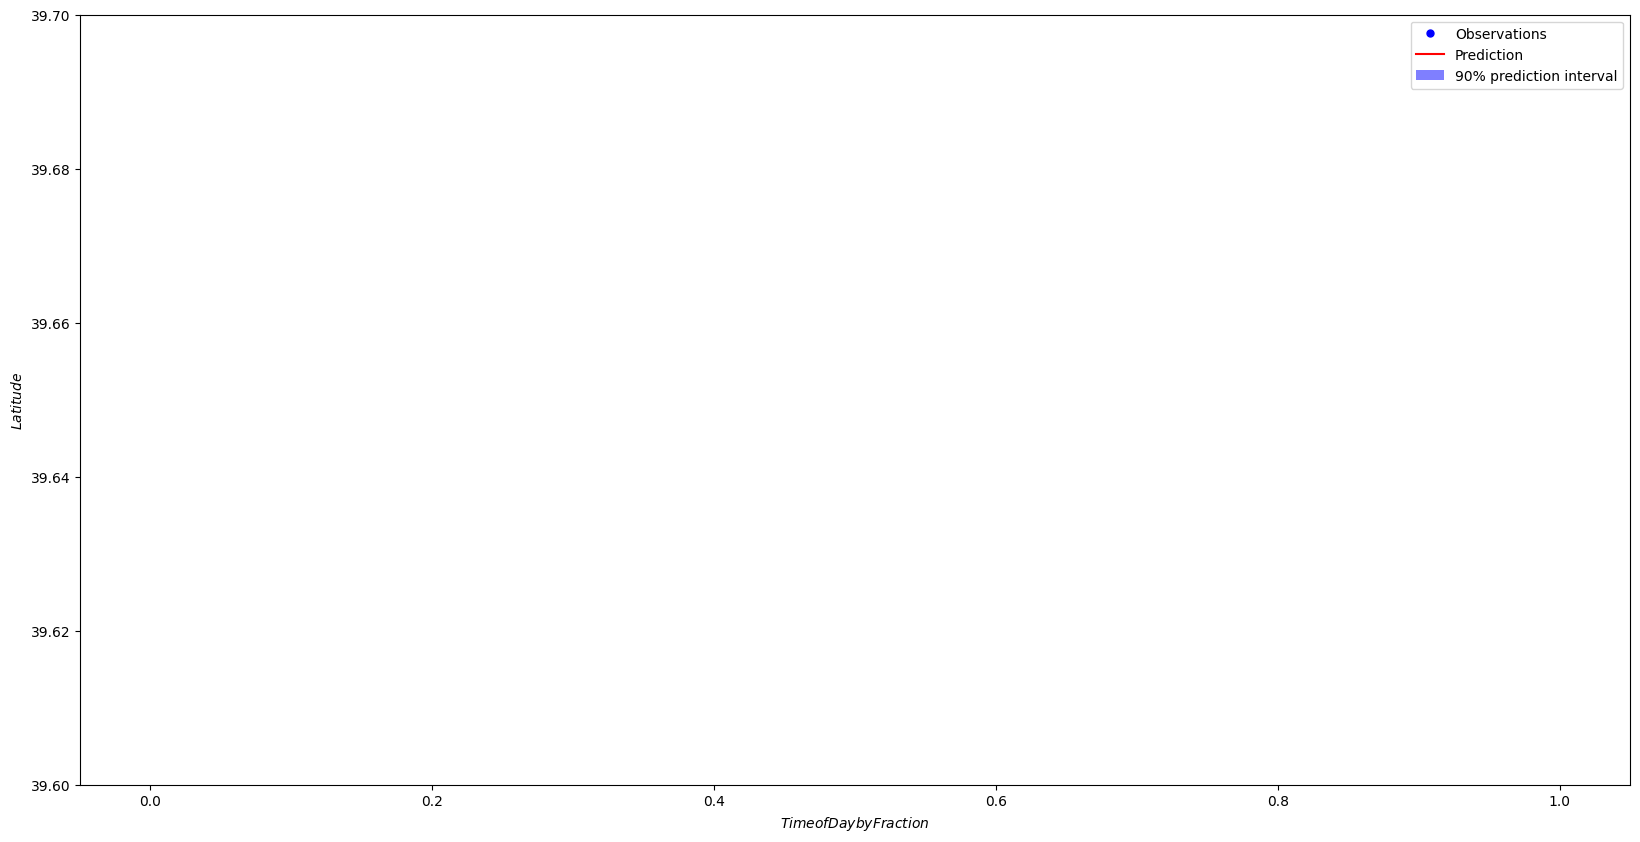

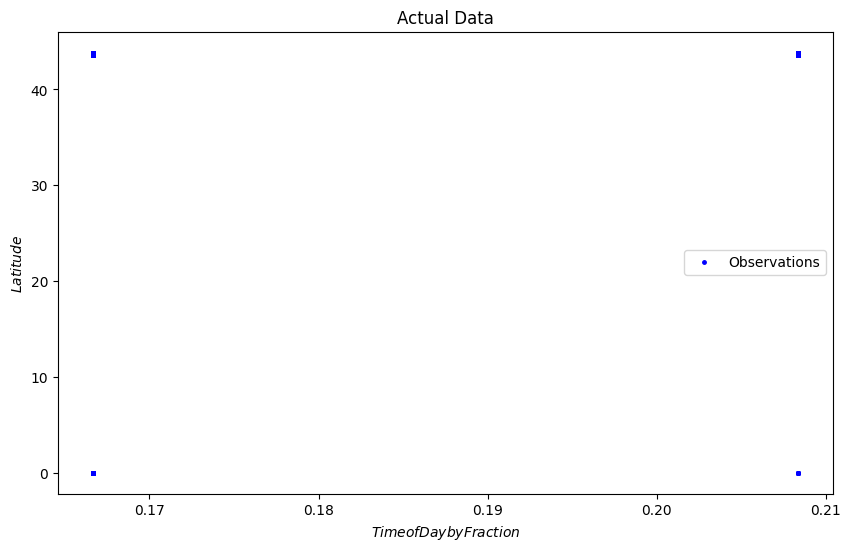

In [22]:


# First the noiseless case
X = np.atleast_2d(df['timeint'].values).T
# Observations
y = np.atleast_2d(df['LAT_WGS84'].values).T
y = y.ravel()

# Mesh the input space for evaluations of the real function, the prediction and its MSE
xx = np.atleast_2d(np.linspace(0, 1, 913)).T
xx = xx.astype(np.float32)

alpha = 0.95
clf = GradientBoostingRegressor(
    loss='quantile',  # Try 'ls' for least squares or 'lad' for least absolute deviation
    n_estimators=1000,  # Increase the number of estimators
    max_depth=5,  # Increase the depth of the trees
    learning_rate=0.01
)

# Step 1: Check Data
print("X shape:", X.shape)
print("y shape:", y.shape)
print("XX shape:", xx.shape)

# Step 2: Hyperparameters
# You can try different hyperparameter settings here
# clf = GradientBoostingRegressor(loss='ls', n_estimators=1000, max_depth=5, learning_rate=0.01)

# Step 3: Fit the model and make predictions
clf.fit(X, y)
y_upper = clf.predict(xx)

clf.set_params(alpha=1.0 - alpha)
clf.fit(X, y)
y_lower = clf.predict(xx)

clf.set_params(loss='quantile')
clf.fit(X, y)
y_pred = clf.predict(xx)

# Step 4: Print results for debugging
print("X data:", X[:5])  # Print first 5 data points in X
print("y data:", y[:5])  # Print first 5 data points in y
print("y_pred:", y_pred[:5])  # Print first 5 predictions
print("y_upper:", y_upper[:5])  # Print first 5 upper bound predictions
print("y_lower:", y_lower[:5])  # Print first 5 lower bound predictions

# Plot the function, the prediction, and the 90% confidence interval based on the MSE
plt.figure(figsize=(20, 10))
plt.plot(X, np.ravel(y), 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('$Time of Day by Fraction$')
plt.ylabel('$Latitude$')
plt.ylim(39.6, 39.7)
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(X, y, 'b.', markersize=5, label=u'Observations')
plt.xlabel('$Time of Day by Fraction$')
plt.ylabel('$Latitude$')
plt.title('Actual Data')
plt.legend()
plt.show()

ypred2=y_pred



X shape: (5707, 1)
y shape: (5707,)
XX shape: (913, 1)
X data: [[0.16666667]
 [0.16666667]
 [0.16666667]
 [0.20833333]
 [0.16666667]]
y data: [-79.23495526 -79.61821819 -79.51875893 -79.3788698  -79.21243507]
y_pred: [-79.58762797 -79.58762797 -79.58762797 -79.58762797 -79.58762797]
y_upper: [-79.23978832 -79.23978832 -79.23978832 -79.23978832 -79.23978832]
y_lower: [-79.58762797 -79.58762797 -79.58762797 -79.58762797 -79.58762797]


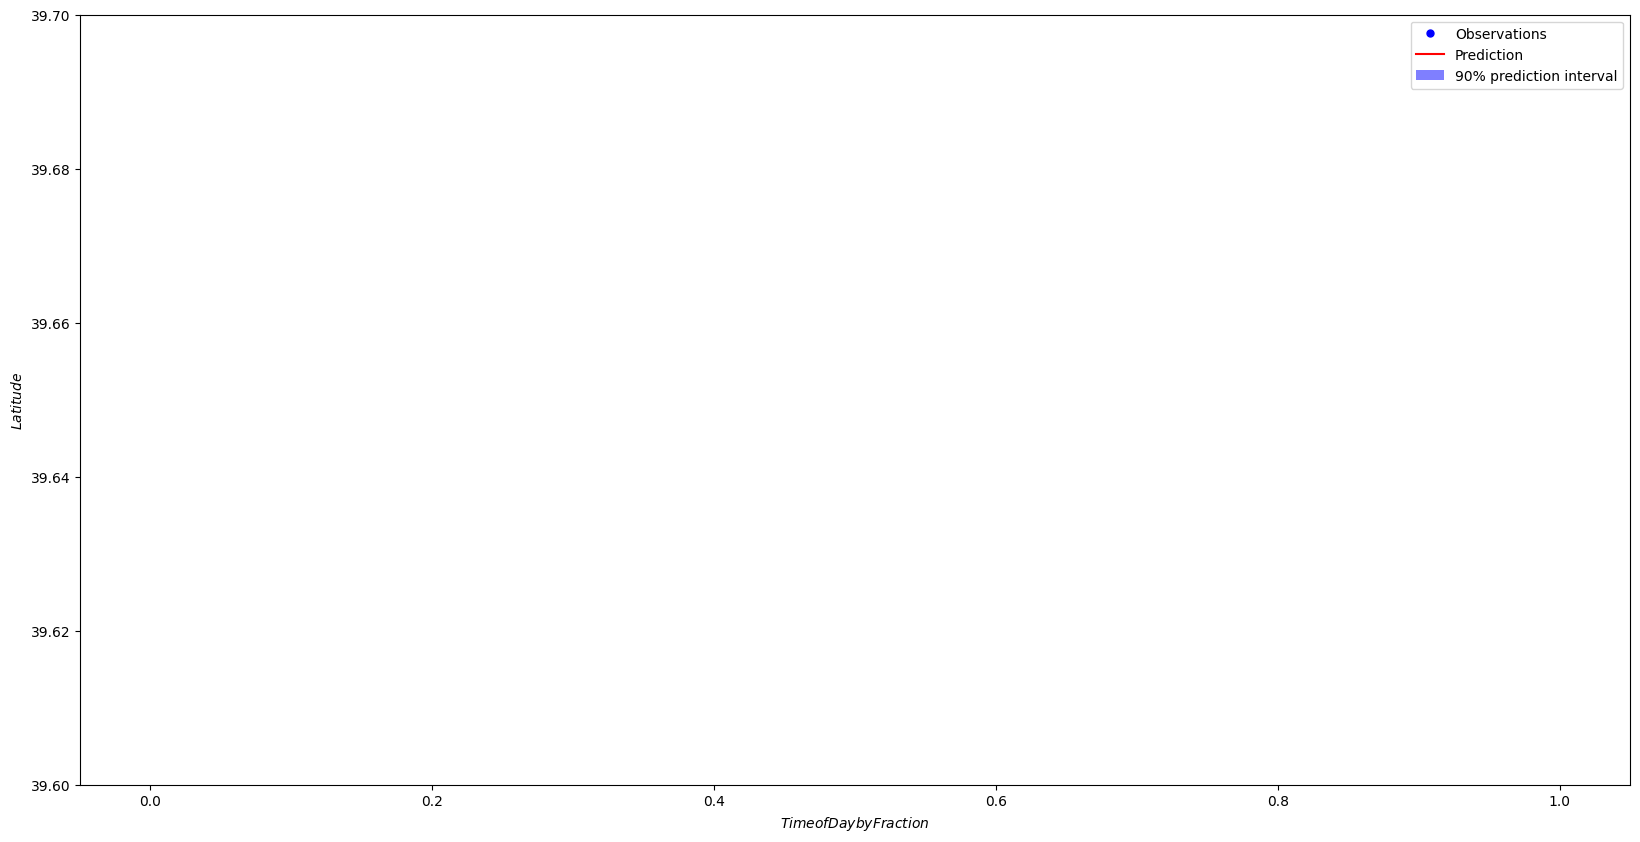

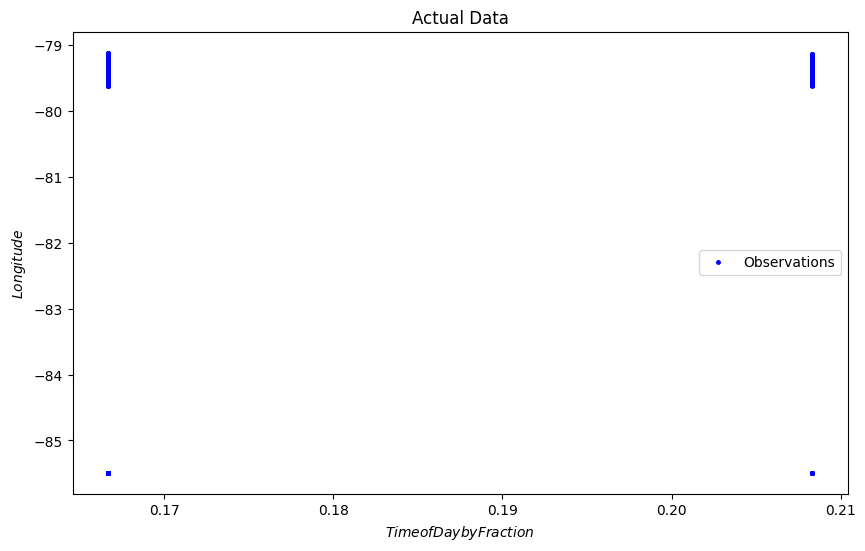

In [23]:


# First the noiseless case
X = np.atleast_2d(df['timeint'].values).T
# Observations
y = np.atleast_2d(df['LONG_WGS84'].values).T
y = y.ravel()

# Mesh the input space for evaluations of the real function, the prediction and its MSE
xx = np.atleast_2d(np.linspace(0, 1, 913)).T
xx = xx.astype(np.float32)

alpha = 0.95
clf = GradientBoostingRegressor(
    loss='quantile',  # Try 'ls' for least squares or 'lad' for least absolute deviation
    n_estimators=1000,  # Increase the number of estimators
    max_depth=5,  # Increase the depth of the trees
    learning_rate=0.01
)

# Step 1: Check Data
print("X shape:", X.shape)
print("y shape:", y.shape)
print("XX shape:", xx.shape)

# Step 2: Hyperparameters
# You can try different hyperparameter settings here
# clf = GradientBoostingRegressor(loss='ls', n_estimators=1000, max_depth=5, learning_rate=0.01)

# Step 3: Fit the model and make predictions
clf.fit(X, y)
y_upper = clf.predict(xx)

clf.set_params(alpha=1.0 - alpha)
clf.fit(X, y)
y_lower = clf.predict(xx)

clf.set_params(loss='quantile')
clf.fit(X, y)
y_pred = clf.predict(xx)

# Step 4: Print results for debugging
print("X data:", X[:5])  # Print first 5 data points in X
print("y data:", y[:5])  # Print first 5 data points in y
print("y_pred:", y_pred[:5])  # Print first 5 predictions
print("y_upper:", y_upper[:5])  # Print first 5 upper bound predictions
print("y_lower:", y_lower[:5])  # Print first 5 lower bound predictions

# Plot the function, the prediction, and the 90% confidence interval based on the MSE
plt.figure(figsize=(20, 10))
plt.plot(X, np.ravel(y), 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('$Time of Day by Fraction$')
plt.ylabel('$Latitude$')
plt.ylim(39.6, 39.7)
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(X, y, 'b.', markersize=5, label=u'Observations')
plt.xlabel('$Time of Day by Fraction$')
plt.ylabel('$Longitude$')
plt.title('Actual Data')
plt.legend()
plt.show()

ypred1=y_pred



In [25]:
# Map points of events
m5 = folium.Map(location=[43.70, -79.42], zoom_start=14)
for i in range(len(ypred1)):
    folium.CircleMarker([ypred2[i], ypred1[i]],
                        radius=4,
                        popup=str(i),
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m5)
m5

In [26]:
import folium

# Sample data for markers (latitude, longitude, and marker color)
marker_data = [
    (37.7749, -122.4194, 'red'),
    (34.0522, -118.2437, 'blue'),
    (40.7128, -74.0060, 'green'),
    (41.8781, -87.6298, 'orange'),
]

# Create a map centered on a specific location
map_center = [39.8283, -98.5795]  # USA coordinates
zoom_level = 5
map_object = folium.Map(location=map_center, zoom_start=zoom_level)

# Add markers to the map
for lat, lon, color in marker_data:
    marker = folium.Marker(location=[lat, lon], popup=f"Latitude: {lat}, Longitude: {lon}")
    marker.add_child(folium.Popup(f"Click me!"))
    marker.add_to(map_object)

    # Define a JavaScript function to change marker color on click
    change_color_js = f"""
        function changeColor(e){{
            e.target.setIcon(new L.Icon({{
                iconUrl: 'http://leafletjs.com/examples/custom-icons/leaf-{color}.png',
                iconSize: [38, 95],
                iconAnchor: [22, 94],
                popupAnchor: [-3, -76],
                shadowUrl: 'http://leafletjs.com/examples/custom-icons/leaf-shadow.png',
                shadowSize: [68, 95],
                shadowAnchor: [22, 94]
            }}));
        }}
        marker.on('click', changeColor);
    """

    # Create a custom HTML element to inject the JavaScript code
    custom_js = folium.Element(f"<script>{change_color_js}</script>")
    marker.add_child(custom_js)

# Display the map
map_object.save("clickable_markers_map.html")


In [30]:
import folium

# Sample data for markers (latitude, longitude, and marker color)
marker_data = [
    (37.7749, -122.4194, 'red'),
    (34.0522, -118.2437, 'blue'),
    (40.7128, -74.0060, 'green'),
    (41.8781, -87.6298, 'orange'),
]

# Create a map centered on a specific location
map_center = [39.8283, -98.5795]  # USA coordinates
zoom_level = 5
map_object = folium.Map(location=map_center, zoom_start=zoom_level)

# Define a JavaScript function to change marker color on click
change_color_js = """
    function changeColor(e) {
        var colors = ['red', 'blue', 'green', 'orange'];
        var currentColor = e.target.options.icon.options.iconColor;
        var currentIndex = colors.indexOf(currentColor);
        var newIndex = (currentIndex + 1) % colors.length;
        var newColor = colors[newIndex];
        e.target.setIcon(new L.Icon({iconUrl: 'http://leafletjs.com/examples/custom-icons/leaf-'+newColor+'.png', iconSize: [38, 95]}));
    }
"""

# Add markers to the map
for lat, lon, color in marker_data:
    icon_url = f'http://leafletjs.com/examples/custom-icons/leaf-{color}.png'
    marker_icon = folium.CustomIcon(icon_url, icon_size=(38, 95))
    marker = folium.Marker(
        location=[lat, lon],
        popup=f"Latitude: {lat}, Longitude: {lon}",
        icon=marker_icon,
    )
    marker.add_child(folium.Popup(f"Click me!"))
    marker.add_to(map_object)

    # Create a custom HTML element to inject the JavaScript code
    custom_js = folium.Element(f"<script>{change_color_js}</script>")
    marker.add_child(custom_js)

# Display the map
map_object.save("clickable_markers_map.html")
